In [ ]:
from datetime import datetime
#import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
#from tqdm import tqdm
import networkx as nx
import json

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
from shapely.geometry import Point
from shapely.geometry import Polygon
import shapely

In [ ]:
CRS_NYC = 'EPSG:2263'
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/citibike/exports'
EDGE_COUNTS_DIR = f'{EXPORTS_DIR}/edge_counts'
WBR_TRIPS_DIR = f'{EXPORTS_DIR}/wbr_trips'

In [ ]:
def peek(df):
    display(df.iloc[:3])
    print(len(df))
    
def hash_station_id(station_id):
    try:
        float_id = float(station_id)
        int_id = int(float(station_id))
        if int_id == float_id:
            return str(int_id)
        else:
            return str(float_id)
    except:
        return str(station_id)

In [7]:
date_strings = [
  '201601',
  '201602',
  '201603',
  '201604',
  '201605',
  '201606',
  '201607',
  '201608',
  '201609',
  '201610',
  '201611',
  '201612',
  '201701',
  '201702',
  '201703',
  '201704',
  '201705',
  '201706',
  '201707',
  '201708',
  '201709',
  '201710',
  '201711',
  '201712',
  '201801',
  '201802',
  '201803',
  '201804',
  '201805',
  '201806',
  '201807',
  '201808',
  '201809',
  '201810',
  '201811',
  '201812',
  '201901',
  '201902',
  '201903',
  '201904',
  '201905',
  '201906',
  '201907',
  '201908',
  '201909',
  '201910',
  '201911',
  '201912',
  '202001',
  '202002',
  '202003',
  '202004',
  '202005',
  '202006',
  '202007',
  '202008',
  '202009',
  '202010',
  '202011',
  '202012',
]

In [8]:
wbr_dfs = [pd.read_csv(f'{WBR_TRIPS_DIR}/{s}_trips.csv') for s in date_strings]

In [9]:
wbr_dt_df = pd.concat(wbr_dfs)
wbr_dt_df['datetime'] = pd.to_datetime(wbr_dt_df['start_time'])
wbr_dt_df['date'] = pd.to_datetime(wbr_dt_df['start_time']).dt.date
wbr_dt_df = wbr_dt_df.sort_values(by=['date'])

In [10]:
def get_attrs_df(df=wbr_dt_df, attrs=[]):
    df = df.groupby(by=(['date'] + attrs)).agg({'od_pair': 'count'})
    df = df.rename(columns={'od_pair': 'count'})
    df = df.reset_index(level=1)
    return df

In [11]:
def plot_attr_df(df, attr, title=''):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))
    
    total_df = df.reset_index().groupby(by=['date']).agg({'count': 'sum'})
    
    attr_values = set(df[attr])
    for i, attr_value in enumerate(attr_values):
        count_df = df[df[attr] == attr_value][['count']]
        pct_df = count_df / total_df
        
        ax[0].plot(count_df, color=f'#ffcc80', label=attr_value, zorder=1)
        ax[0].plot(count_df.rolling(window=365).mean(), color='#000', zorder=2)
        
        ax[1].plot(pct_df, color=f'C', label=attr_value, zorder=1)
        ax[1].plot(pct_df.rolling(window=365).mean(), color='#000', zorder=2)
        
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title(title)
    
    plt.show()

In [12]:
def plot_df(df, attr, title=''):
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.plot(df[attr], zorder=2)
    ax.plot(df[attr].rolling(window=365).mean(), color='#000', zorder=2)
    plt.show()

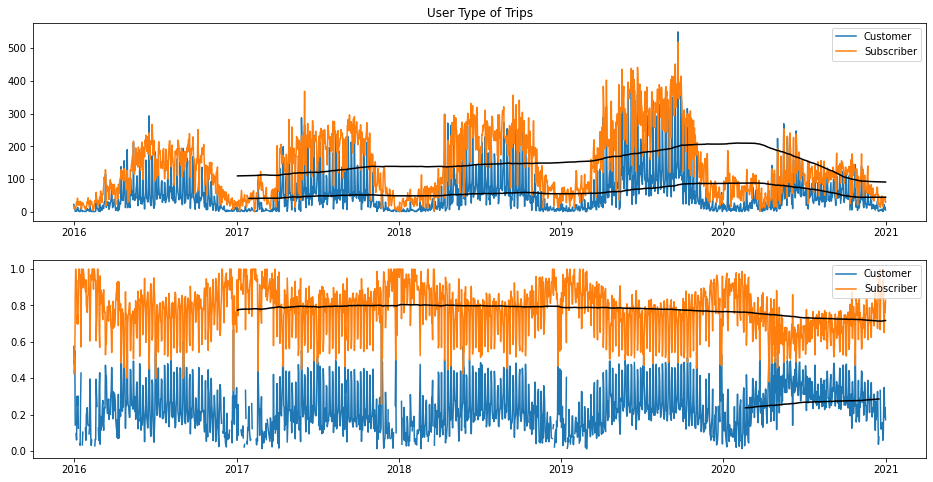

In [128]:
cdf = get_attrs_df(wbr_dt_df, ['user_type'])
plot_attr_df(cdf, 'user_type', 'User Type of Trips')

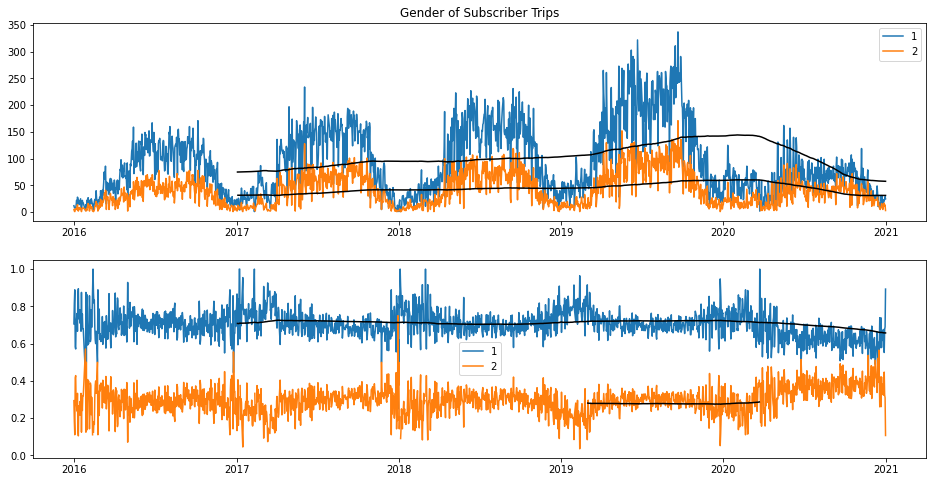

In [129]:
sdf = wbr_dt_df[(wbr_dt_df['user_type'] == 'Subscriber') & (wbr_dt_df['gender'] != 0)]
cdf = get_attrs_df(sdf, ['gender'])
plot_attr_df(cdf, 'gender', 'Gender of Subscriber Trips')

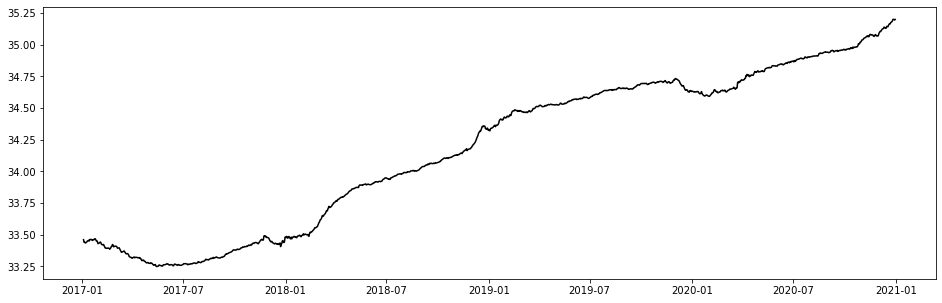

In [134]:
sdf = wbr_dt_df[wbr_dt_df['user_type'] == 'Subscriber']
sdf = sdf[~sdf['birth_year'].isna()]
sdf['age'] = pd.to_datetime(sdf['date']).dt.year - sdf['birth_year']
sdf = sdf.groupby(by=['date']).agg({'age': 'mean'})
plot_df(sdf, 'age', 'Age of Subscriber Trips')

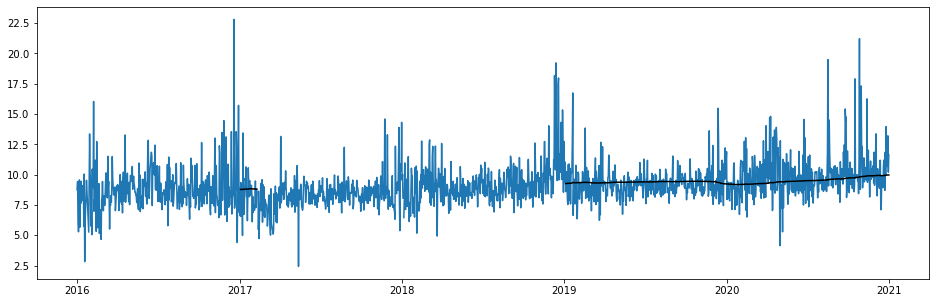

In [141]:
sdf = wbr_dt_df[wbr_dt_df['user_type'] == 'Subscriber']
sdf = sdf[~sdf['birth_year'].isna()]
sdf['age'] = pd.to_datetime(sdf['date']).dt.year - sdf['birth_year']
sdf = sdf.groupby(by=['date']).agg({'age': 'std'})
plot_df(sdf, 'age', 'Age of Subscriber Trips')

In [142]:
wdf = wbr_dt_df
wdf

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_lat,start_lon,end_station_id,end_station_name,end_lat,end_lon,bike_id,user_type,birth_year,gender,od_pair,datetime,date
348,2046,1/1/2016 19:53:24,1/1/2016 20:27:30,410,Suffolk St & Stanton St,40.720664,-73.985180,532,S 5 Pl & S 4 St,40.710451,-73.960876,15128,Subscriber,1978.0,1,"('410', '532')",2016-01-01 19:53:24,2016-01-01
272,1740,1/1/2016 16:36:40,1/1/2016 17:05:41,361,Allen St & Hester St,40.716059,-73.991908,3093,N 6 St & Bedford Ave,40.717452,-73.958509,22091,Customer,NaN,0,"('361', '3093')",2016-01-01 16:36:40,2016-01-01
273,1724,1/1/2016 16:36:58,1/1/2016 17:05:42,361,Allen St & Hester St,40.716059,-73.991908,3093,N 6 St & Bedford Ave,40.717452,-73.958509,18328,Subscriber,1966.0,2,"('361', '3093')",2016-01-01 16:36:58,2016-01-01
274,1669,1/1/2016 16:37:47,1/1/2016 17:05:36,361,Allen St & Hester St,40.716059,-73.991908,3093,N 6 St & Bedford Ave,40.717452,-73.958509,19426,Customer,NaN,0,"('361', '3093')",2016-01-01 16:37:47,2016-01-01
629,1329,1/1/2016 14:55:02,1/1/2016 15:17:11,532,S 5 Pl & S 4 St,40.710451,-73.960876,410,Suffolk St & Stanton St,40.720664,-73.985180,22032,Subscriber,1962.0,1,"('532', '410')",2016-01-01 14:55:02,2016-01-01


In [145]:
import pickle
f = open('graph_path_dict.pkl', 'rb')
graph_path_dict = pickle.load(f)

In [150]:
import math
def distance(lat1, lon1, lat2, lon2):
    return math.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

In [156]:
tqdm.pandas()
wdf['distance'] = wdf.progress_apply(lambda x: distance(x['start_lat'], x['start_lon'], x['end_lat'], x['end_lon']), axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355546/355546 [00:18<00:00, 19130.88it/s]


In [157]:
wdf['speed'] = wdf['distance'] / wdf['trip_duration']

In [357]:
wsdf = wdf[~((wdf['start_lat'] == wdf['end_lat']) | (wdf['start_lon'] == wdf['end_lon']))]
sdf = wsdf[pd.to_datetime(wsdf['date']).dt.year >= 2020].groupby(by=['bike_id']).agg({'speed': 'mean'}).reset_index()

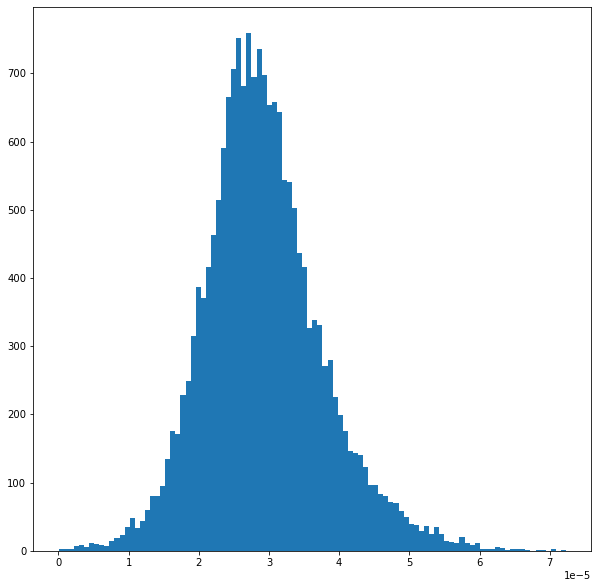

In [358]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(sdf['speed'], bins=100)
plt.show()

In [168]:
am_dfs = [pd.read_csv(f'{EXPORTS_DIR}/adjacency_matrices/csv/{s}_trip_count.csv') for s in date_strings]

In [182]:
for i, am_df in enumerate(am_dfs):
    am_dfs[i] = am_df.set_index(am_df.columns[0])

In [170]:
station_coords = pd.read_csv(f'{EXPORTS_DIR}/station_coords.csv')

In [271]:
sa_gdf = gpd.read_file(f'{DATA_DIR}/geo/bridge_area.shp', crs=CRS_NYC)
sa_gdf = sa_gdf.to_crs(CRS_LATLON)

In [272]:
sa_geom = sa_gdf.dissolve()

In [273]:
sa_geom = shapely.ops.unary_union(sa_geom.geometry)

In [235]:
bbox = (
    sa_geom.bounds.iloc[0].minx,
    sa_geom.bounds.iloc[0].maxx,
    sa_geom.bounds.iloc[0].miny,
    sa_geom.bounds.iloc[0].maxy,
)

In [260]:
def is_in_service_area_poly(lat, lon):
    return sa_geom.contains(Point(lon, lat))

In [281]:
tqdm.pandas()
station_coords['area'] = station_coords.progress_apply(lambda x: is_in_service_area_poly(x['lat'], x['lon']), axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4995/4995 [00:09<00:00, 552.70it/s]


In [282]:
station_coords[station_coords['area'] == True]

,id,date,lat,lon,area
0,116,201310,40.741776,-74.001497,True
1,116,202004,40.743000,-74.001000,True
2,119,201310,40.696089,-73.978034,True
3,120,201310,40.686768,-73.959282,True
4,127,201310,40.731724,-74.006744,True
...,...,...,...,...,...
4990,SYS033,202102,40.728487,-74.011693,True
4991,SYS035,202102,40.728660,-74.011980,True
4992,SYS035,202102,40.728660,-74.011980,True
4993,SYS037,202107,40.716878,-73.983755,True


[]

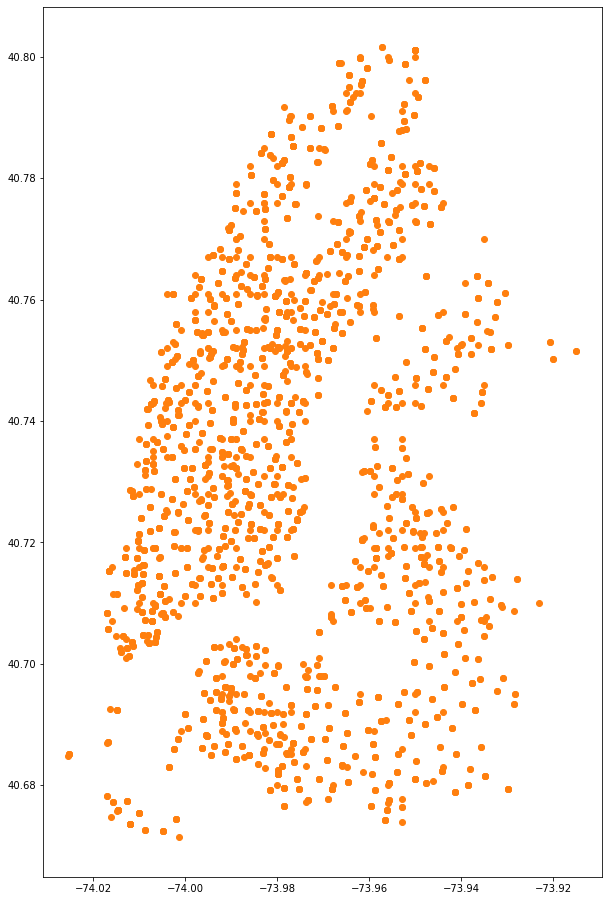

In [283]:
fig, ax = plt.subplots(figsize=(16, 16))
#gpd.GeoDataFrame({}, geometry=sa_geom, crs=CRS_LATLON).plot(ax=ax)
sc = station_coords[station_coords['area'] == True]
sgdf = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(sc['lon'], sc['lat']), crs=CRS_LATLON)
sgdf.plot(ax=ax, color='C1')
plt.plot()

In [288]:
def is_in_service_area(station, date):
    df = station_coords[station_coords['id'] == station]
    if len(df) < 1:
        return False
    return df['area'].iloc[0]

In [295]:
station_dict = {}
for i, date_string in tqdm(list(enumerate(date_strings))):
    cx = [hash_station_id(c) for c in am_dfs[i].columns if is_in_service_area(c, date_string)]
    station_dict[date_string] = cx

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:10<00:00,  1.18s/it]


In [302]:
for i, am_df in enumerate(am_dfs):
    am_dfs[i].columns = [hash_station_id(c) for c in am_dfs[i].columns]
    am_dfs[i] = am_dfs[i].transpose()
    am_dfs[i].columns = [hash_station_id(c) for c in am_dfs[i].columns]
    am_dfs[i] = am_dfs[i].transpose()

In [304]:
def filter_amdf(amdf, date_string):
    return amdf[station_dict[date_string]].transpose()[station_dict[date_string]].transpose()

In [307]:
amfx = [filter_amdf(amdf, date_strings[i]) for i, amdf in enumerate(am_dfs)]

In [324]:
count = pd.Series([x.sum().sum() for x in am_dfs])

In [325]:
wbr_counts = pd.Series([len(x) for x in wbr_dfs])

In [332]:
pct = wbr_counts / count

[]

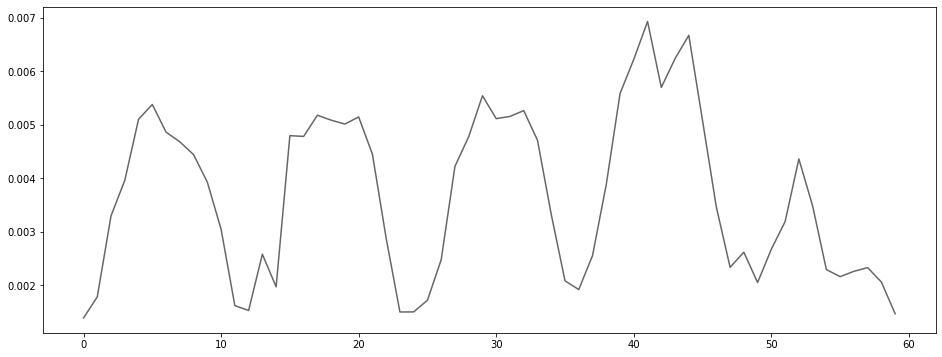

In [333]:
fig, ax = plt.subplots(figsize=(16, 6))
pct.plot(ax=ax, color='#666')
plt.plot()

In [322]:
len(count)

60